# Imputación basada en modelos

Una de las téncicas con mayor eficiencia reportada para imputar valores faltantes para ser usados en modelos de machine learning son los Mutiple Imputation Chained Equations (MICE) que que consisten en probar múltiples algoritmos de imputación y contrastar cuáles ayudan a predecir los valores existentes en el dataset _van Buuren, S., & Groothuis-Oudshoorn,K. (2011)_. Dado que existen múltiples formas de hacerlo es importante decidir cuales de estos dan mejores resultados y son más personalizables o de fácil uso en otros casos de uso. 

Se optó por miceforest por dar esta posibilidad de configuración. Se comparó previamente `sklearn.impute.IterativeImputer` sin embargo había parámetros importantes que se dejaban de lado como el tipo de missing values que se estaban tratando de imputar, si eran o no dependientes de las otras variables y el orden de la imputación que adoptaría.

Dadas estas deficiencias y por la facilidad de uso se optó por la librería [miceforest](https://pypi.org/project/miceforest/) que está basada en el mismo algoritmo pero con una forma iterativa de árbol con lgbm

> **IMPORTANTE:** miceforest tiene problemas con versiones anteriores de scipy por lo que se recomienda hacer primero un update de la librería `!pip install scipy --upgrade`y reiniciar el entorno de ejecución antes de ejecutar las celdas



### Referencias:

van Buuren, S., & Groothuis-Oudshoorn, K. (2011). mice: Multivariate Imputation by Chained Equations in R. Journal of Statistical Software, 45(3), 1–67. https://doi.org/10.18637/jss.v045.i03

In [1]:
#Actualización de scipy. Por favor reinicie el entorno de ejecución después de ejecutar esta celda y no la ejecute de nuevo una vez reiniciado
!pip install scipy --upgrade

     |████████████████████████████████| 38.1 MB 1.3 MB/s 
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [2]:
#instalación de miceforest
!pip install miceforest

     |████████████████████████████████| 41 kB 17 kB/s 
     |████████████████████████████████| 2.0 MB 9.7 MB/s 
  Attempting uninstall: lightgbm
    Found existing installation: lightgbm 2.2.3
    Uninstalling lightgbm-2.2.3:
      Successfully uninstalled lightgbm-2.2.3


In [3]:
#Importar librerías
import miceforest as mf
import missingno as msno
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats

In [4]:
#Clonar repositorio con datos
!git clone --branch Edher-Markov-imputation https://github.com/maindufeu/WIDS.git

Cloning into 'WIDS'...
remote: Enumerating objects: 25, done.
remote: Counting objects: 100% (25/25), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 25 (delta 7), reused 22 (delta 4), pack-reused 0
Unpacking objects: 100% (25/25), done.


In [56]:
#Lectura de datos
path = 'WIDS/train.csv'
train = pd.read_csv(path, sep=',') 

path = 'WIDS/test.csv'
test = pd.read_csv(path, sep=',') 

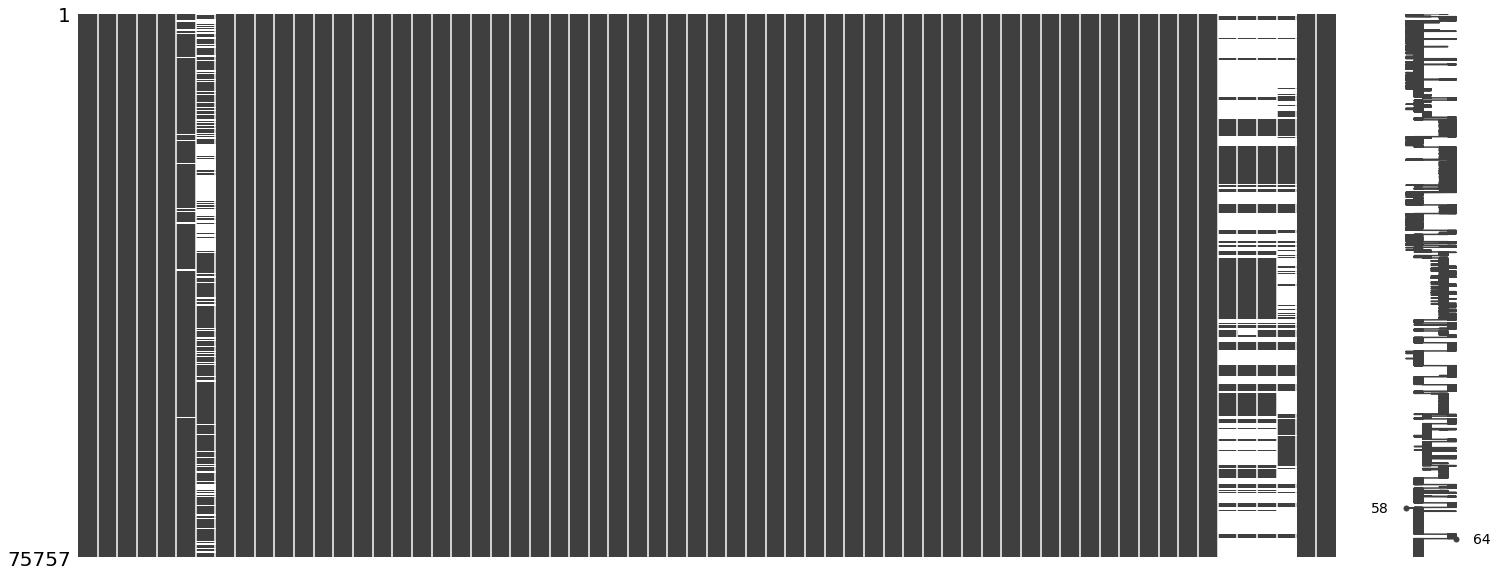

In [11]:
#visualización de missing values de train
msno.matrix(train)

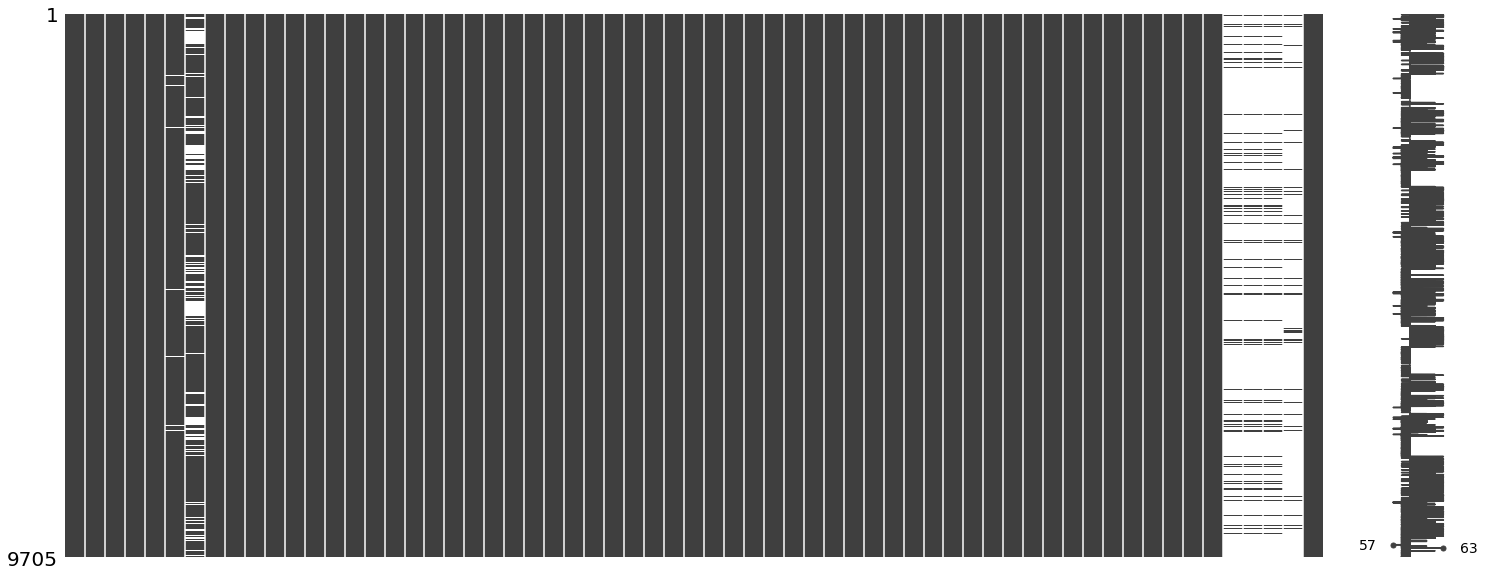

In [10]:
#visualización de missing values de test
msno.matrix(test)

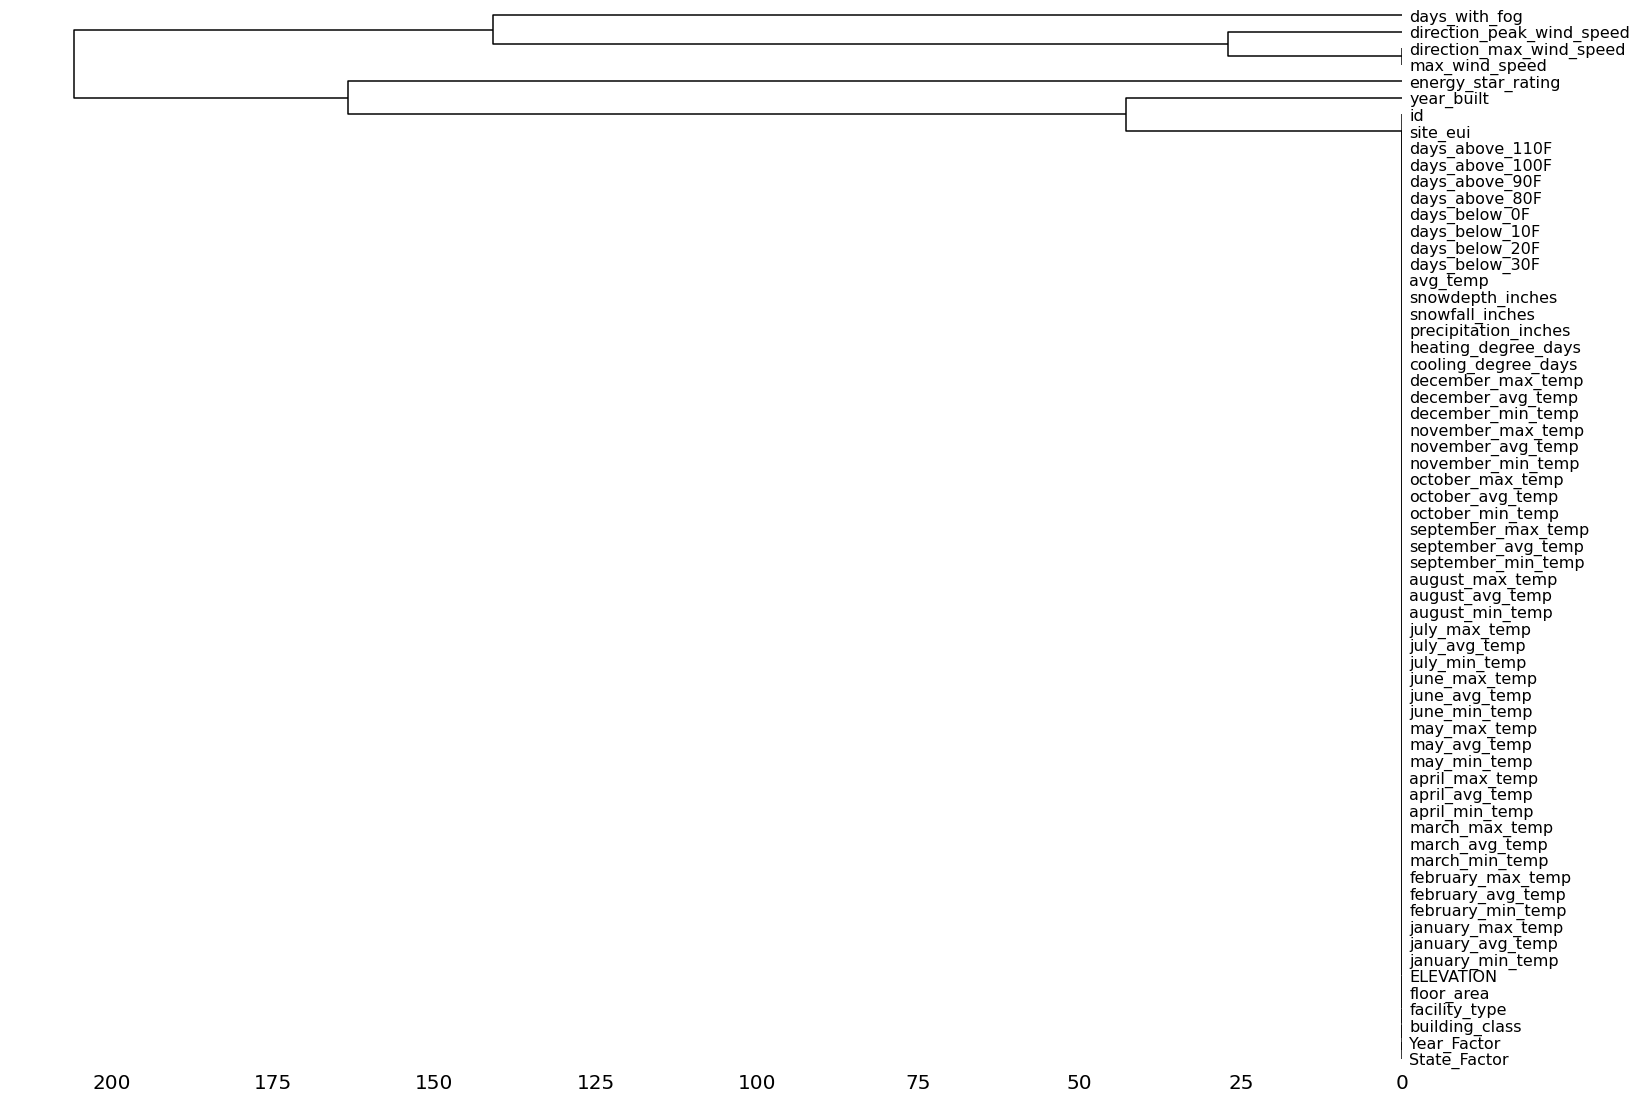

In [12]:
#visualización de correlación de missing values por dendrograma
msno.dendrogram(train)

In [14]:
#columnas con missing values
columns_na = train.columns[train.isna().any()].tolist()
columns_na

['year_built',
 'energy_star_rating',
 'direction_max_wind_speed',
 'direction_peak_wind_speed',
 'max_wind_speed',
 'days_with_fog']

Es importante que las variables categóricas sean pasadas como category y no como objeto para que lgbm pueda reconocerlas

In [16]:
df = train

df.loc[:, df.dtypes == 'object'] =\
    df.select_dtypes(['object'])\
    .apply(lambda x: x.astype('category'))

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75757 entries, 0 to 75756
Data columns (total 64 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   Year_Factor                75757 non-null  int64   
 1   State_Factor               75757 non-null  category
 2   building_class             75757 non-null  category
 3   facility_type              75757 non-null  category
 4   floor_area                 75757 non-null  float64 
 5   year_built                 73920 non-null  float64 
 6   energy_star_rating         49048 non-null  float64 
 7   ELEVATION                  75757 non-null  float64 
 8   january_min_temp           75757 non-null  int64   
 9   january_avg_temp           75757 non-null  float64 
 10  january_max_temp           75757 non-null  int64   
 11  february_min_temp          75757 non-null  int64   
 12  february_avg_temp          75757 non-null  float64 
 13  february_max_temp          7575

In [26]:
# Creación del kernel. 
kernel = mf.ImputationKernel(
  df,
  datasets=4, # sets rresultantes
  save_all_iterations=True,
  random_state=1989
)
# Run the MICE algorithm for 3 iterations on each of the datasets
kernel.mice(3)

In [20]:
#Ver un dataset imputado
kernel.complete_data(0)

,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,january_max_temp,february_min_temp,february_avg_temp,february_max_temp,march_min_temp,march_avg_temp,march_max_temp,april_min_temp,april_avg_temp,april_max_temp,may_min_temp,may_avg_temp,may_max_temp,june_min_temp,june_avg_temp,june_max_temp,july_min_temp,july_avg_temp,july_max_temp,august_min_temp,august_avg_temp,august_max_temp,september_min_temp,september_avg_temp,september_max_temp,october_min_temp,october_avg_temp,october_max_temp,november_min_temp,november_avg_temp,november_max_temp,december_min_temp,december_avg_temp,december_max_temp,cooling_degree_days,heating_degree_days,precipitation_inches,snowfall_inches,snowdepth_inches,avg_temp,days_below_30F,days_below_20F,days_below_10F,days_below_0F,days_above_80F,days_above_90F,days_above_100F,days_above_110F,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog,site_eui,id
0,1,State_1,Commercial,Grocery_store_or_food_market,61242.0,1942.0,11.0,2.4,36,50.500000,68,35,50.589286,73,40,53.693548,80,41,55.500000,78,46,56.854839,84,50,60.500000,90,52,62.725806,84,52,62.161290,85,52,64.650000,90,47,63.016129,83,43,53.800000,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,1.0,1.0,12.0,248.682615,0
1,1,State_1,Commercial,Warehouse_Distribution_or_Shipping_center,274000.0,1955.0,45.0,1.8,36,50.500000,68,35,50.589286,73,40,53.693548,80,41,55.500000,78,46,56.854839,84,50,60.500000,90,52,62.725806,84,52,62.161290,85,52,64.650000,90,47,63.016129,83,43,53.800000,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,1.0,1.0,12.0,26.500150,1
2,1,State_1,Commercial,Retail_Enclosed_mall,280025.0,1951.0,97.0,1.8,36,50.500000,68,35,50.589286,73,40,53.693548,80,41,55.500000,78,46,56.854839,84,50,60.500000,90,52,62.725806,84,52,62.161290,85,52,64.650000,90,47,63.016129,83,43,53.800000,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,1.0,1.0,12.0,24.693619,2
3,1,State_1,Commercial,Education_Other_classroom,55325.0,1980.0,46.0,1.8,36,50.500000,68,35,50.589286,73,40,53.693548,80,41,55.500000,78,46,56.854839,84,50,60.500000,90,52,62.725806,84,52,62.161290,85,52,64.650000,90,47,63.016129,83,43,53.800000,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,1.0,1.0,12.0,48.406926,3
4,1,State_1,Commercial,Warehouse_Nonrefrigerated,66000.0,1985.0,100.0,2.4,36,50.500000,68,35,50.589286,73,40,53.693548,80,41,55.500000,78,46,56.854839,84,50,60.500000,90,52,62.725806,84,52,62.161290,85,52,64.650000,90,47,63.016129,83,43,53.800000,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,1.0,1.0,12.0,3.899395,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75752,6,State_11,Commercial,Office_Uncategorized,20410.0,1995.0,8.0,36.6,28,43.451613,56,34,47.672414,64,35,49.354839,71,40,56.266667,89,45,59.193548,88,47,63.566667,91,54,66.951613,87,52,68.612903,91,44,61.383333,79,39,55.403226,68,40,51.283333,71,24,38.532258,51,260,3772,45.03,1.4,1,55.147541,6,0,0,0,25,3,0,0,330.0,340.0,20.6,261.0,132.918411,75752
75753,6,State_11,Residential,5plus_Unit_Building,40489.0,1910.0,98.0,36.6,28,43.451613,56,34,47.672414,64,35,49.354839,71,40,56.266667,89,45,59.193548,88,47,63.566667,91,54,66.951613,87,52,68.612903,91,44,61.383333,79,39,55.403226,68,40,51.283333,71,24,38.532258,51,260,3772,45.03,1.4,1,55.147541,6,0,0,0,25,3,0,0,1.0,1.0,1.0,261.0,39.483672,75753
75754,6,State_11,Commercial,Commercial_Other,28072.0,1917.0,81.0,36.6,26,36.612903,48,30,41.637931,58,29,41.338710,62,34,50.183333,79,40,52.145161,79,41,56.233333,86,48,58.758065,81,48,61.612903,87,41,53.783333,73,37,47.661290,59,34,44.650000,62,15,30.338710,46,55,6218,106.32,36.6,438,47.911202,26,2,0,0,6,0

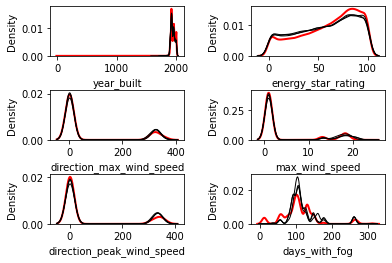

In [24]:
# visualización de las distribuciones imputadas y marcada en rojo la distribución original
kernel.plot_imputed_distributions(wspace=0.5,hspace=0.7)

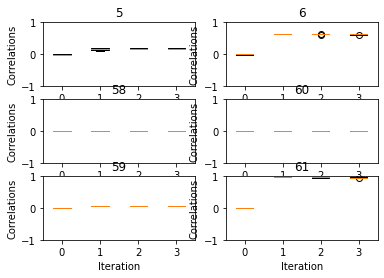

In [27]:
#plot de correlación entre las distribuciones por iteración
kernel.plot_correlations()

In [34]:
#Promedio de datasets resultantes
mice_results = pd.concat([kernel.complete_data(i).loc[:,columns_na] for i in range(3)]).groupby(level=0).mean()

In [37]:
#Redondeo a decimales necesarios
mice_results[columns_na] = mice_results[columns_na].round().astype(int)

In [38]:
#Imputación en dataset original
df[columns_na] = mice_results[columns_na]

In [39]:
#Export
df.to_csv('mice_train.csv')

Para hacerla una función iterativa se puede construir algo así

In [40]:
estados = list(train['State_Factor'].unique())
estados

['State_1', 'State_2', 'State_4', 'State_6', 'State_8', 'State_10', 'State_11']

In [60]:
def mmiceforest(initial_df, iterative_variable, n_datasets, n_iterations, mmc):
  it_categories = list(initial_df[iterative_variable].unique())
  initial_df.loc[:, initial_df.dtypes == 'object'] =initial_df.select_dtypes(['object']).apply(lambda x: x.astype('category'))
  output_df = pd.DataFrame(columns = initial_df.columns)
  for i in it_categories:
    df = initial_df[initial_df[iterative_variable] == i]
    kernel = mf.ImputationKernel(df,datasets=n_datasets, mean_match_candidates=mmc, save_all_iterations=True, random_state=1989)
    kernel.mice(n_iterations)
    kernel.plot_imputed_distributions(wspace=0.5,hspace=0.7)
    kernel.plot_correlations()
    mice_results = pd.concat([kernel.complete_data(i).loc[:,columns_na] for i in range(3)]).groupby(level=0).mean()
    df[columns_na] = mice_results[columns_na].round().astype(int)
    output_df = output_df.append(df, ignore_index = True)
  print(output_df.head(5))
  output_df.to_csv('mice_result.csv') 


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.


  Year_Factor State_Factor building_class  ... days_with_fog    site_eui id
0           1      State_1     Commercial  ...            12  248.682615  0
1           1      State_1     Commercial  ...            12   26.500150  1
2           1      State_1     Commercial  ...            12   24.693619  2
3           1      State_1     Commercial  ...            12   48.406926  3
4           1      State_1     Commercial  ...            12    3.899395  4

[5 rows x 64 columns]


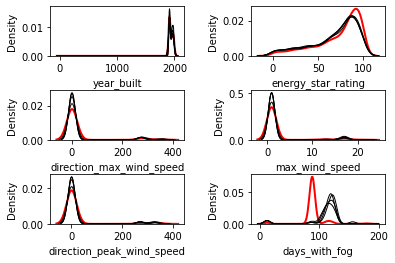

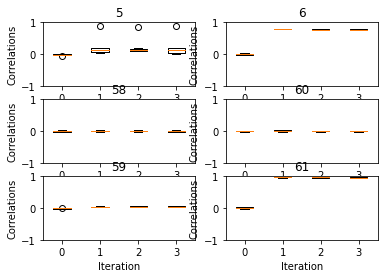

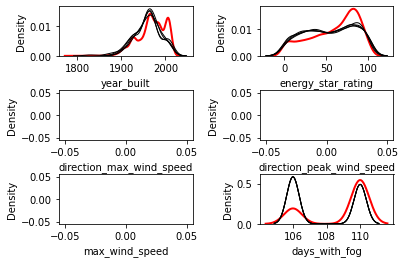

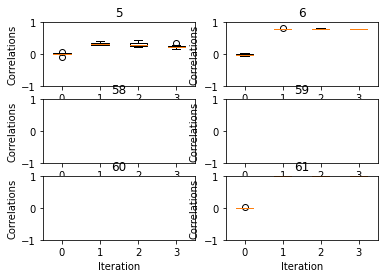

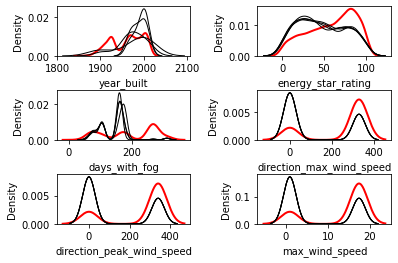

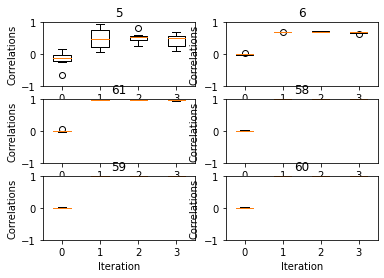

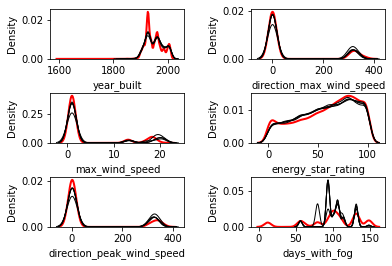

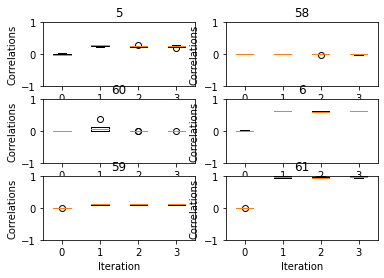

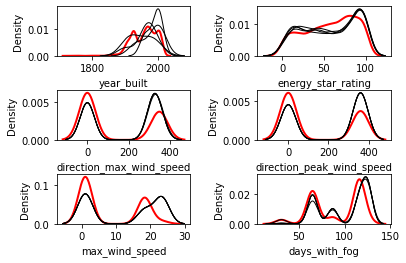

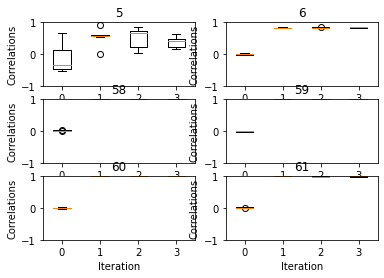

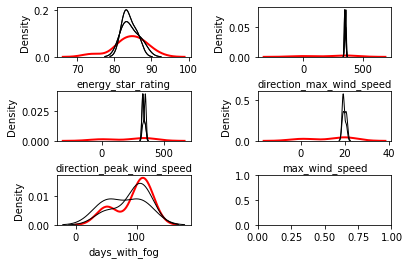

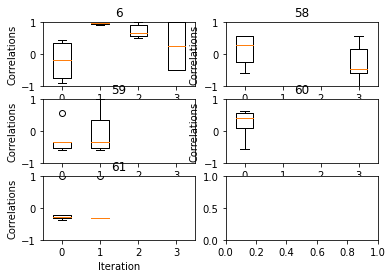

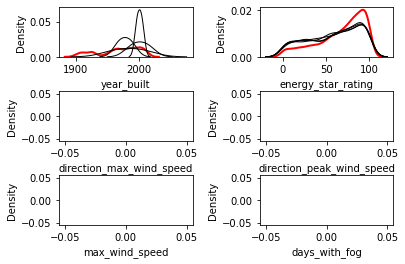

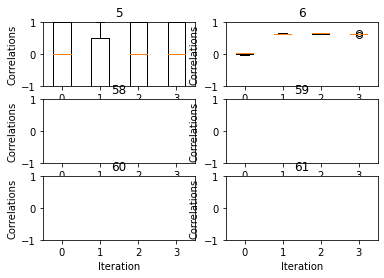

In [61]:
mmiceforest(train, 'State_Factor', 4, 3, 5)